# Import the libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

#from pandas_profiling import ProfileReport

/home/febriyanto/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Preparation

In [2]:
patient_df = pd.read_csv("https://raw.githubusercontent.com/MohammadFebriyanto/Bangkit_Project/master/DATA/patient.csv")
time_df = pd.read_csv("https://raw.githubusercontent.com/MohammadFebriyanto/Bangkit_Project/master/DATA/time.csv")
route_df = pd.read_csv("https://raw.githubusercontent.com/MohammadFebriyanto/Bangkit_Project/master/DATA/route.csv")

In [3]:
time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               52 non-null     object
 1   time               52 non-null     int64 
 2   test               52 non-null     int64 
 3   negative           52 non-null     int64 
 4   confirmed          52 non-null     int64 
 5   released           52 non-null     int64 
 6   deceased           52 non-null     int64 
 7   Seoul              52 non-null     int64 
 8   Busan              52 non-null     int64 
 9   Daegu              52 non-null     int64 
 10  Incheon            52 non-null     int64 
 11  Gwangju            52 non-null     int64 
 12  Daejeon            52 non-null     int64 
 13  Ulsan              52 non-null     int64 
 14  Sejong             52 non-null     int64 
 15  Gyeonggi-do        52 non-null     int64 
 16  Gangwon-do         52 non-null     int64 
 17 

In [4]:
route_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patient_id  212 non-null    int64  
 1   date        212 non-null    object 
 2   province    212 non-null    object 
 3   city        212 non-null    object 
 4   visit       212 non-null    object 
 5   latitude    212 non-null    float64
 6   longitude   212 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 11.7+ KB


In [5]:
patient_df.head()

,patient_id,sex,birth_year,country,region,disease,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state
0,1,female,1984.0,China,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaN,released
1,2,male,1964.0,Korea,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaN,released
2,3,male,1966.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaN,released
3,4,male,1964.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaN,released
4,5,male,1987.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaN,released


In [6]:
patient_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7754 entries, 0 to 7753
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   patient_id        7754 non-null   int64  
 1   sex               678 non-null    object 
 2   birth_year        665 non-null    float64
 3   country           7754 non-null   object 
 4   region            436 non-null    object 
 5   disease           28 non-null     float64
 6   group             86 non-null     object 
 7   infection_reason  154 non-null    object 
 8   infection_order   36 non-null     float64
 9   infected_by       70 non-null     float64
 10  contact_number    53 non-null     float64
 11  confirmed_date    7754 non-null   object 
 12  released_date     55 non-null     object 
 13  deceased_date     36 non-null     object 
 14  state             7754 non-null   object 
dtypes: float64(5), int64(1), object(9)
memory usage: 908.8+ KB


In [7]:
patient_df.columns

Index(['patient_id', 'sex', 'birth_year', 'country', 'region', 'disease',
       'group', 'infection_reason', 'infection_order', 'infected_by',
       'contact_number', 'confirmed_date', 'released_date', 'deceased_date',
       'state'],
      dtype='object')

In [8]:
#profile_patient = ProfileReport(patient_df) 
#profile_time = ProfileReport(time_df) 
#profile_route = ProfileReport(route_df)

In [9]:
#profile_patient

In [10]:
#profile_time

In [11]:
#profile_route

# Feature Engineering

In [12]:
patient_df["birth_year"] = patient_df.birth_year.fillna(0.0).astype(int)
patient_df["birth_year"] = patient_df["birth_year"].map(lambda val: val if val > 0 else np.nan)

In [13]:
patient_df.confirmed_date = pd.to_datetime(patient_df.confirmed_date)

In [14]:
count_id = patient_df.groupby(patient_df.confirmed_date).patient_id.count()

In [15]:
accumulated_count = count_id.cumsum()

In [16]:
import datetime

In [17]:
now = datetime.datetime.now()
now.year

2020

In [18]:
patient_df["age"] = now.year - patient_df["birth_year"]

In [19]:
patient_df["age"].head()

0    36.0
1    56.0
2    54.0
3    56.0
4    33.0
Name: age, dtype: float64

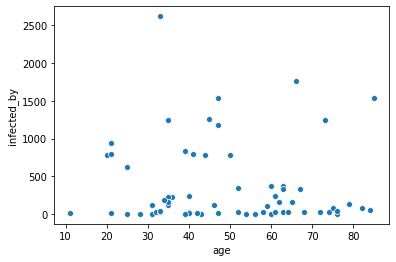

In [20]:
sns.scatterplot(x='age', y='infected_by', data=patient_df)

In [21]:
def group_age(age):
    if age >= 0:
        if age % 10 != 0:
            lower = int(math.floor(age/10.0))*10
            upper = int(math.ceil(age/10.0))*10-1
            return f"{lower}-{upper}"
        else:
            lower = int(age)
            upper = int(age+9)
            return f"{lower}-{upper}"
        return np.nan

In [22]:
group_age(15)

'10-19'

In [23]:
patient_df["age_range"] = patient_df["age"].apply(group_age)

In [24]:
age_order=patient_df['age_range'].unique()

In [25]:
age_order

array(['30-39', '50-59', '20-29', '60-69', '40-49', '70-79', '80-89',
       '10-19', None, '0-9', '90-99'], dtype=object)

In [26]:
age_order = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']

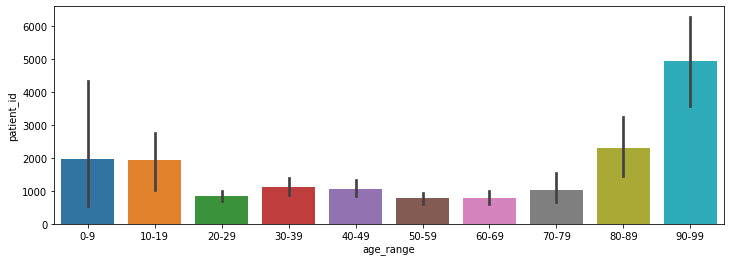

In [27]:
plt.figure(figsize=(12,4))
sns.barplot(x='age_range',y='patient_id',data=patient_df, order=age_order)

In [28]:
patient_df['sex']

0       female
1         male
2         male
3         male
4         male
         ...  
7749       NaN
7750       NaN
7751       NaN
7752       NaN
7753       NaN
Name: sex, Length: 7754, dtype: object

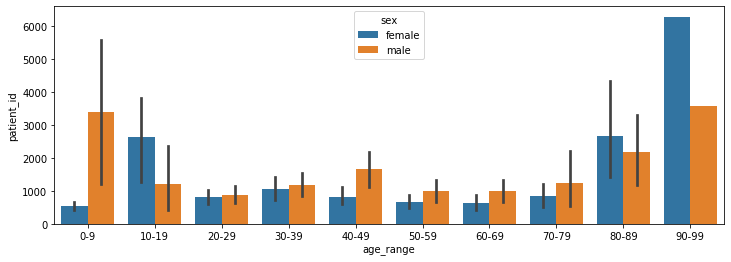

In [29]:
plt.figure(figsize=(12,4))
sns.barplot(x='age_range',y='patient_id',data=patient_df, hue='sex', order=age_order)

In [30]:
time_df.head()

,date,time,test,negative,confirmed,released,deceased,Seoul,Busan,Daegu,...,Sejong,Gyeonggi-do,Gangwon-do,Chungcheongbuk-do,Chungcheongnam-do,Jeollabuk-do,Jeollanam-do,Gyeongsangbuk-do,Gyeongsangnam-do,Jeju-do
0,2020-01-20,16,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-21,16,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-22,16,4,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-23,16,22,21,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-24,16,27,25,2,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [31]:
time_df['confirmed']

0        1
1        1
2        1
3        1
4        2
5        2
6        3
7        4
8        4
9        4
10       6
11      11
12      12
13      15
14      15
15      16
16      18
17      23
18      24
19      24
20      27
21      27
22      28
23      28
24      28
25      28
26      28
27      29
28      30
29      31
30      51
31     104
32     204
33     433
34     602
35     833
36     977
37    1261
38    1766
39    2337
40    3150
41    3736
42    4212
43    4812
44    5328
45    5766
46    6284
47    6767
48    7134
49    7382
50    7513
51    7755
Name: confirmed, dtype: int64

In [32]:
patient = patient_df

In [33]:
column_date = ["confirmed_date","released_date","deceased_date"]

In [34]:
for col in column_date:
    patient[col] = pd.to_datetime(patient[col])

In [35]:
patient["released_date"]

0      2020-02-06
1      2020-02-05
2      2020-02-12
3      2020-02-09
4      2020-03-02
          ...    
7749          NaT
7750          NaT
7751          NaT
7752          NaT
7753          NaT
Name: released_date, Length: 7754, dtype: datetime64[ns]

In [36]:
patient.head()

,patient_id,sex,birth_year,country,region,disease,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state,age,age_range
0,1,female,1984.0,China,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaT,released,36.0,30-39
1,2,male,1964.0,Korea,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaT,released,56.0,50-59
2,3,male,1966.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaT,released,54.0,50-59
3,4,male,1964.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaT,released,56.0,50-59
4,5,male,1987.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaT,released,33.0,30-39


In [37]:
patient["time_to_release"] = patient["released_date"] - patient["confirmed_date"]
patient["time_to_death"] = patient["deceased_date"] - patient["confirmed_date"]
patient["duration"] = patient[["time_to_release","time_to_death"]].min(axis=1)
patient["duration_days"] = patient["duration"].dt.days

In [38]:
patient["age_range"].unique()

array(['30-39', '50-59', '20-29', '60-69', '40-49', '70-79', '80-89',
       '10-19', None, '0-9', '90-99'], dtype=object)

In [39]:
range_of_age = sorted(set([ar for ar in patient["age_range"] if ar != None]))

In [40]:
patient['state_by_gender'] = patient['state'] + '_' + patient['sex']

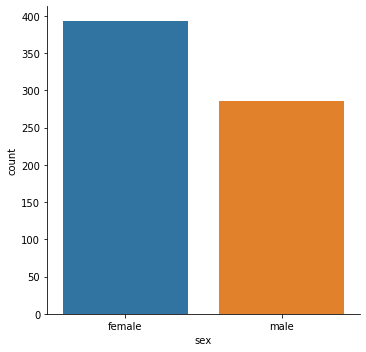

In [41]:
sns.catplot(x='sex', kind='count', data=patient_df);

/home/febriyanto/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/febriyanto/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


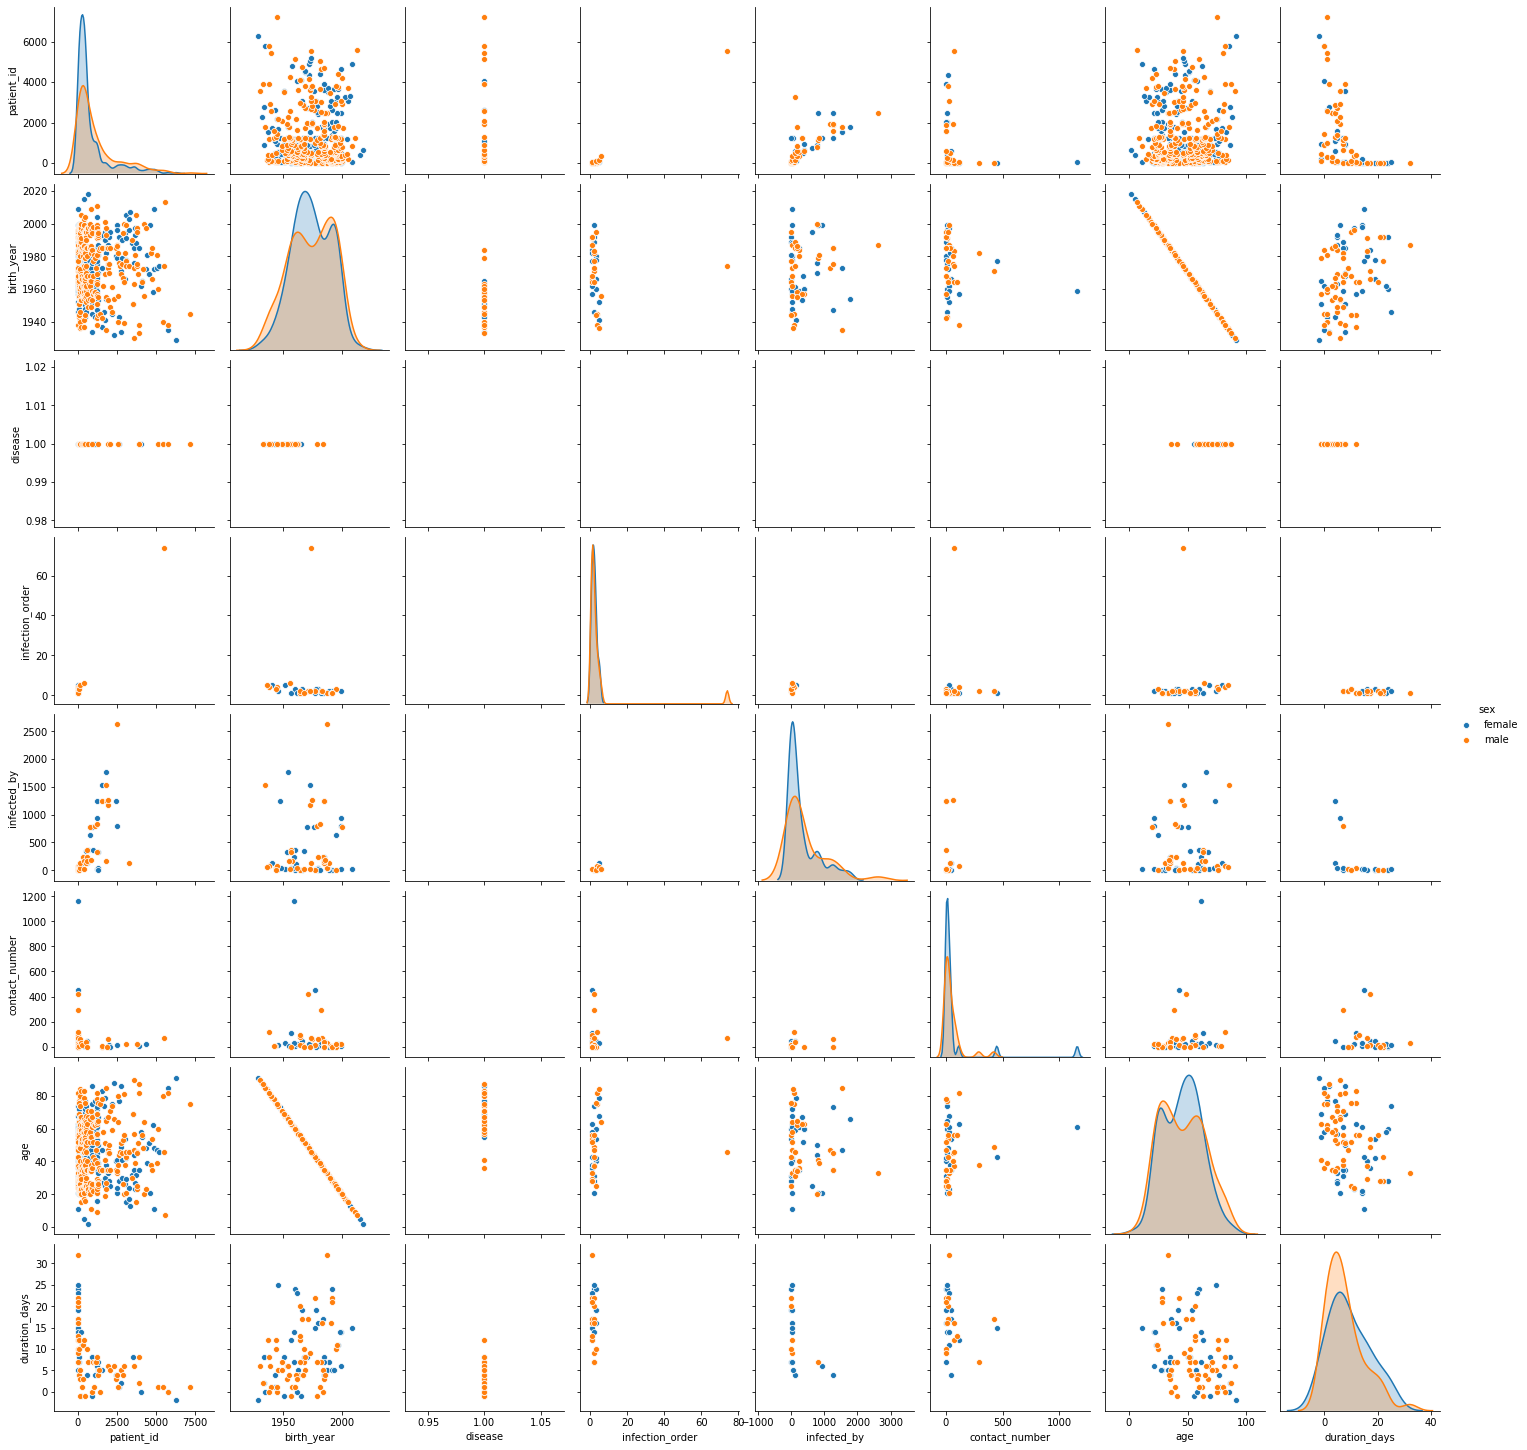

In [42]:
sns.pairplot(patient_df, hue='sex');

In [43]:
patient_df['infection_reason'].unique()

array(['visit to Wuhan', 'contact with patient',
       'contact with patient in Japan', 'residence in Wuhan',
       'visit to Thailand', 'contact with patient in Singapore',
       'visit to China', nan, 'visit to Daegu', 'pilgrimage to Israel',
       'contact with patient in Daegu', 'visit to Vietnam',
       'visit to Japan', 'visit to Italy', 'visit to ooo'], dtype=object)

In [44]:
infection_reason = ['visit to Wuhan', 'contact with patient',
       'contact with patient in Japan', 'residence in Wuhan',
       'visit to Thailand', 'contact with patient in Singapore',
       'visit to China', 'visit to Daegu', 'pilgrimage to Israel',
       'contact with patient in Daegu', 'visit to Vietnam',
       'visit to Japan', 'visit to Italy', 'visit to ooo']

In [45]:
numerical_infection = []

for i in infection_reason:
    numeric = patient_df[patient_df['infection_reason'] == i]['patient_id'].count()
    numerical_infection.append(numeric)

In [46]:
numerical_infection

[8, 76, 1, 2, 2, 2, 2, 50, 6, 1, 1, 1, 1, 1]

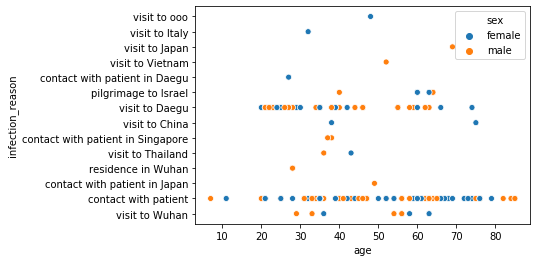

In [47]:
sns.scatterplot(x='age', y='infection_reason', hue='sex', data=patient_df)

<BarContainer object of 14 artists>

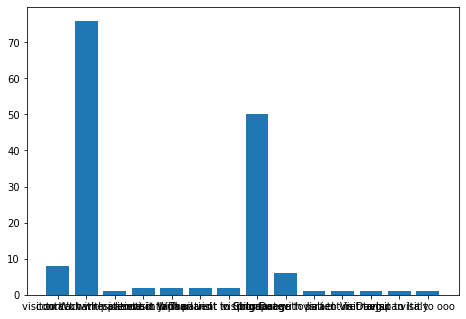

In [48]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(patient_df['infection_reason'].dropna().unique(), numerical_infection)

In [49]:
released = patient_df[patient_df.state == 'released']
isolated = patient_df[patient_df.state == 'isolated']
dead = patient_df[patient_df.state == 'deceased']

In [50]:
#profile_released = ProfileReport(released)
#profile_dead = ProfileReport(dead)

In [51]:
#profile_dead

In [52]:
#profile_released

# Confirmed Cases

Text(0.5, 1.0, 'Confirmed Case')

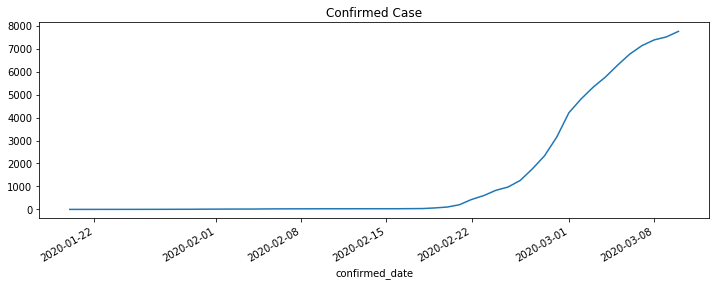

In [53]:
plt.figure(figsize=(12,4))
accumulated_count.plot()
plt.title('Confirmed Case')

In [54]:
route_df.head()

,patient_id,date,province,city,visit,latitude,longitude
0,1,2020-01-19,Incheon,Jung-gu,airport,37.460459,126.440680
1,1,2020-01-20,Incheon,Seo-gu,hospital_isolated,37.478832,126.668558
2,2,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.562143,126.801884
3,2,2020-01-23,Seoul,Jung-gu,hospital_isolated,37.567454,127.005627
4,3,2020-01-20,Incheon,Jung-gu,airport,37.460459,126.440680


In [55]:
from datetime import date, timedelta
from sklearn.cluster import KMeans

In [56]:
clustering = route_df.loc[:,['patient_id','latitude','longitude']]

In [57]:
clustering.head()

,patient_id,latitude,longitude
0,1,37.460459,126.440680
1,1,37.478832,126.668558
2,2,37.562143,126.801884
3,2,37.567454,127.005627
4,3,37.460459,126.440680


In [58]:
clustering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patient_id  212 non-null    int64  
 1   latitude    212 non-null    float64
 2   longitude   212 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 5.1 KB


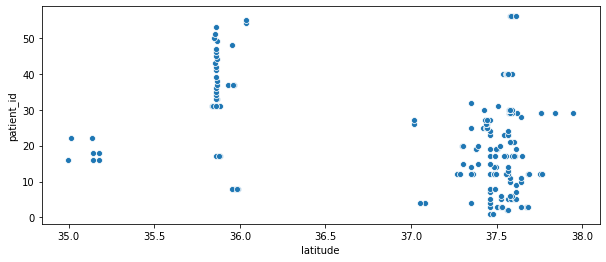

In [59]:
plt.figure(figsize=(10,4))
sns.scatterplot(x='latitude',y='patient_id',data=clustering)

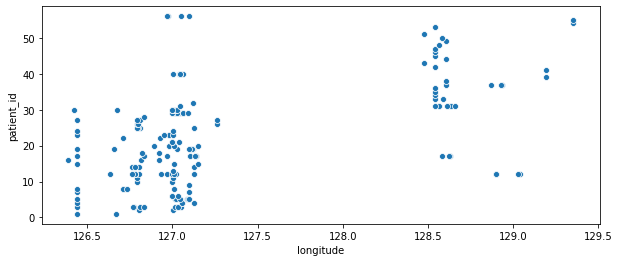

In [60]:
plt.figure(figsize=(10,4))
sns.scatterplot(x='longitude',y='patient_id',data=clustering)

# Checking number of Cluster

In [61]:
cluster_kmeans = range(1,8)
kmeans = [KMeans(n_clusters=i) for i in cluster_kmeans]

In [62]:
X = route_df[['longitude']]
Y = route_df[['latitude']]

In [63]:
score = [kmeans[i].fit(Y).score(Y) for i in range(len(kmeans))]

In [64]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(clustering[clustering.columns[1:3]])
clustering['cluster_label'] = kmeans.fit_predict(clustering[clustering.columns[1:3]])
centers = kmeans.cluster_centers_
labels = kmeans.predict(clustering[clustering.columns[1:3]])

In [65]:
clustering[clustering['cluster_label']==3]['cluster_label'].count()

0

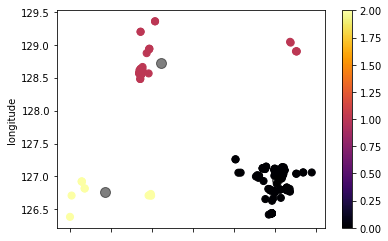

In [66]:
clustering.plot.scatter(x='latitude', y='longitude', c=labels, s=50, cmap='inferno')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)

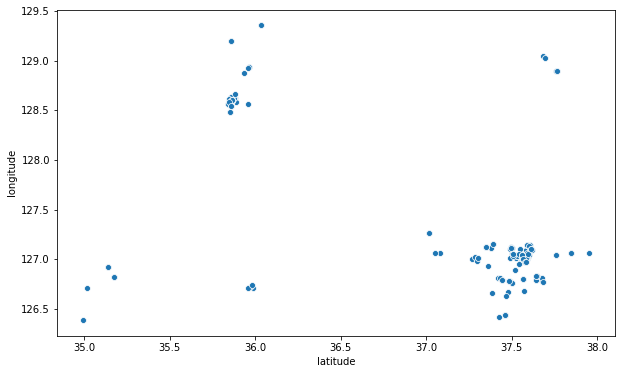

In [67]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='latitude',y='longitude', data=clustering)

# Data Prep for LSTM

In [68]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

In [69]:
data = count_id.resample('D').first().fillna(0).cumsum()
data = data[10:]

In [70]:
data

confirmed_date
2020-01-30       7.0
2020-01-31      11.0
2020-02-01      12.0
2020-02-02      15.0
2020-02-03      15.0
2020-02-04      16.0
2020-02-05      21.0
2020-02-06      24.0
2020-02-07      24.0
2020-02-08      24.0
2020-02-09      27.0
2020-02-10      28.0
2020-02-11      28.0
2020-02-12      28.0
2020-02-13      28.0
2020-02-14      28.0
2020-02-15      28.0
2020-02-16      30.0
2020-02-17      30.0
2020-02-18      38.0
2020-02-19      65.0
2020-02-20     103.0
2020-02-21     203.0
2020-02-22     432.0
2020-02-23     601.0
2020-02-24     832.0
2020-02-25     975.0
2020-02-26    1262.0
2020-02-27    1766.0
2020-02-28    2337.0
2020-02-29    3149.0
2020-03-01    4211.0
2020-03-02    4811.0
2020-03-03    5327.0
2020-03-04    5765.0
2020-03-05    6283.0
2020-03-06    6766.0
2020-03-07    7133.0
2020-03-08    7381.0
2020-03-09    7512.0
2020-03-10    7754.0
Freq: D, Name: patient_id, dtype: float64

In [71]:
x = np.arange(len(data)).reshape(-1,1)
y = data.values

In [72]:
y.shape

(41,)

In [73]:
x.shape

(41, 1)

# Regressor Model

In [74]:
model = MLPRegressor(hidden_layer_sizes=[41,22,10], max_iter=50000, alpha=0.0005, random_state=26)
model.fit(x,y)

MLPRegressor(activation='relu', alpha=0.0005, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=[41, 22, 10], learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=50000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=26, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [75]:
test = np.arange(len(data)+7).reshape(-1,1)
pred = model.predict(test)

In [76]:
prediction = pred.round().astype(int)
week = [data.index[0]+timedelta(days=i) for i in range(len(prediction))]
dt_idx = pd.DatetimeIndex(week)

In [77]:
predicted_count = pd.Series(prediction,dt_idx)

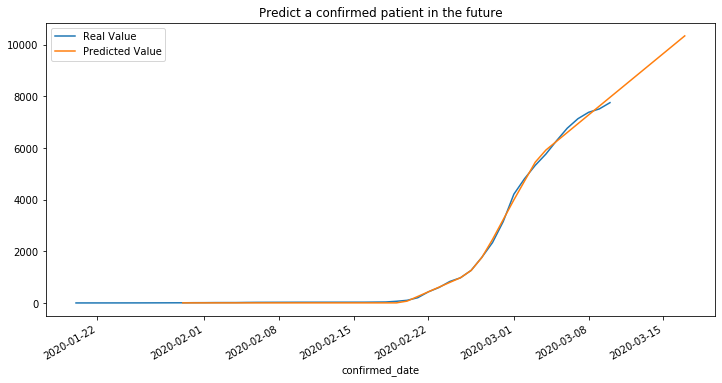

In [78]:
plt.figure(figsize=(12,6))
accumulated_count.plot()
predicted_count.plot()
plt.title('Predict a confirmed patient in the future')
L = plt.legend()
L.get_texts()[0].set_text('Real Value')
L.get_texts()[1].set_text('Predicted Value')

# LSTM With Tensorflow

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

/home/febriyanto/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/febriyanto/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/febriyanto/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/febriyanto/.local/lib/python3.6/site-packages/tensorflow/python/framework

In [80]:
df = pd.DataFrame(data)
df.columns = ['Number of Confirmed']
df.tail(7)

,Number of Confirmed
confirmed_date,
2020-03-04,5765.0
2020-03-05,6283.0
2020-03-06,6766.0
2020-03-07,7133.0
2020-03-08,7381.0
2020-03-09,7512.0
2020-03-10,7754.0


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2020-01-30 to 2020-03-10
Freq: D
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Number of Confirmed  41 non-null     float64
dtypes: float64(1)
memory usage: 656.0 bytes


In [82]:
data = np.array(df).reshape(-1,1)

In [83]:
train_data = df[:len(df)-7]
test_data = df[len(df)-7:]

In [84]:
scaler = MinMaxScaler()

In [85]:
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [86]:
n_input = 10
n_features = 1

In [87]:
generator = TimeseriesGenerator(train_data, train_data, length=n_input, batch_size=1)

In [88]:
model = Sequential()

In [89]:
model.add(LSTM(units = 50, return_sequences = True, input_shape=(n_input,n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(generator, epochs=30)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/30
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
24/24 [==============================] - 7s 291ms/step - loss: 0.1073
Epoch 2/30
24/24 [==============================] - 1s 35ms/step - loss: 0.0759
Epoch 3/30
24/24 [==============================] - 1s 36ms/step - loss: 0.0405
Epoch 4/30
24/24 [==============================] - 1s 31ms/step - loss: 0.0465
Epoch 5/30
24/24 [==============================] - 1s 36ms/step - loss: 0.0453
Epoch 6/30
24/24 [==============================] - 1s 36ms/step - loss: 0.0258
Epoch 7/30
24/24 [==============================] - 1s 32ms/step - loss: 0.0187
Epoch 8/30
24/24 [==============================] - 1s 34ms/step - loss: 0.0118
Epoch 9/30
24/24 [==============================] - 1s 32ms/step - loss: 0.0159
Epoch 10/30
24/24 [==============================] - 1s 33ms/step -

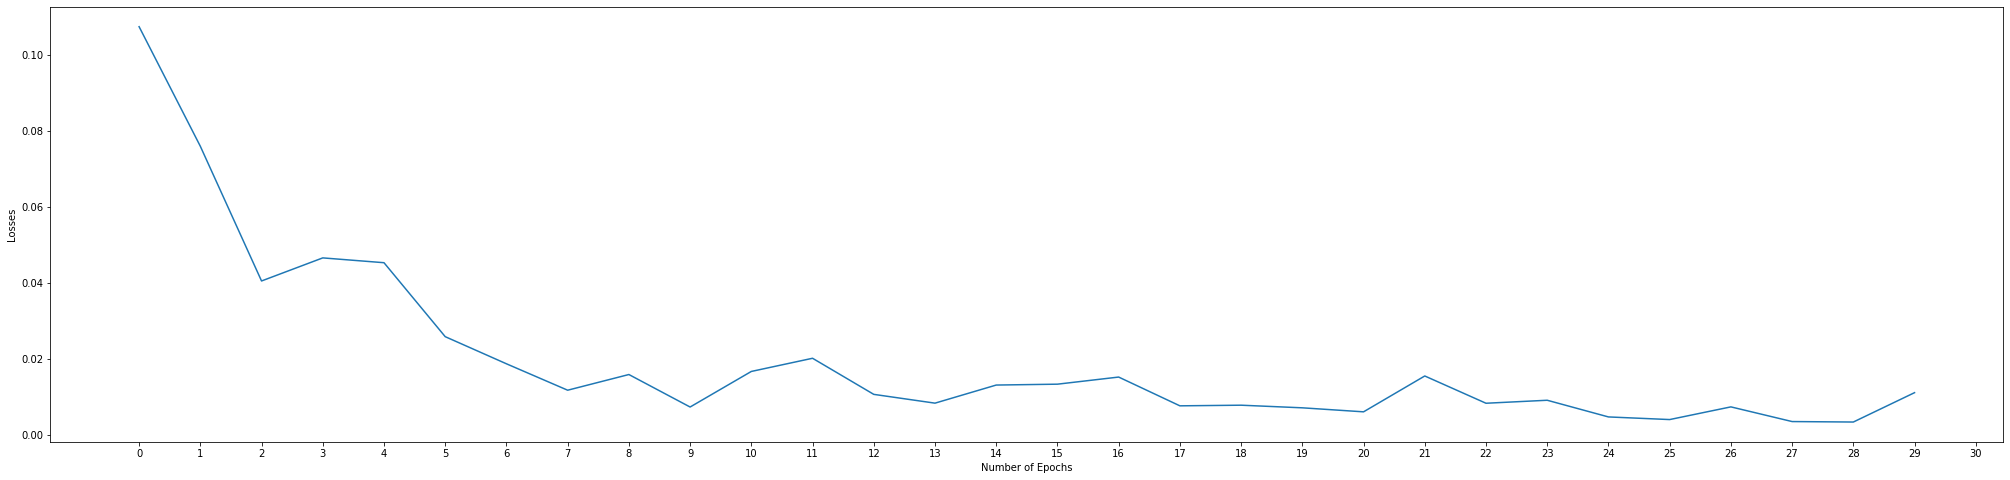

In [90]:
losses = model.history.history['loss']
plt.figure(figsize = (35,8))
plt.xlabel('Number of Epochs')
plt.ylabel('Losses')
plt.xticks(np.arange(0,150,1))
plt.plot(range(len(losses)), losses)

In [91]:
prediction_scaled = []

In [92]:
batch = train_data[-n_input:]
current_batch = batch.reshape((1,n_input,n_features))

In [93]:
for i in range(len(test_data)):
    pred = model.predict(current_batch)[0]
    prediction_scaled.append(pred)
    current_batch = np.append(current_batch[:,1:,:],[[pred]],axis=1)

In [94]:
prediction = pd.DataFrame(scaler.inverse_transform(prediction_scaled))

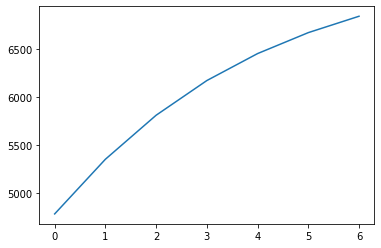

In [95]:
plt.plot(prediction)

In [96]:
prediction

,0
0,4786.148436
1,5354.353396
2,5811.880190
3,6172.485106
4,6452.813818
5,6670.646574
6,6840.885651


# Data Untuk Indonesia

In [97]:
data_Ina = pd.read_csv("https://raw.githubusercontent.com/MohammadFebriyanto/Bangkit_Project/master/DATA/TotalCaseConvir_INA.csv", delimiter=';')

In [98]:
data_Ina.head(3)

,Date,case
0,02/03/2020,2
1,03/03/2020,2
2,04/03/2020,2


In [99]:
data = data_Ina.drop('Date', axis=1)

In [100]:
data = np.array(data).reshape(-1,1)

In [101]:
data = scaler.transform(data)

In [102]:
prediction_scaled_Ina = []
batch = data[-n_input:]
current_batch = batch.reshape((1,n_input,n_features))
for i in range(7):
    pred = model.predict(current_batch)[0]
    prediction_scaled_Ina.append(pred)
    current_batch = np.append(current_batch[:,1:,:],[[pred]],axis=1)

In [103]:
prediction = pd.DataFrame(scaler.inverse_transform(prediction_scaled_Ina))

In [104]:
prediction

,0
0,3846.773848
1,4108.982703
2,4433.874285
3,4801.670320
4,5184.959065
5,5558.101351
6,5901.492989


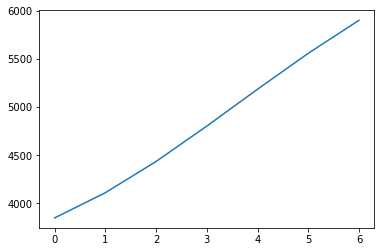

In [105]:
plt.plot(prediction)